In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Label Encoder to convert column 1 (M/B) into ints
from sklearn.preprocessing import LabelEncoder
# X is values in all rows, column 2 through the end (data)
X = df.loc[:, 2:].values

# y is values in all rows, column 1 (class)
y = df.loc[:, 1].values

# Instantiate label encoder class object
le = LabelEncoder()

# Use LabelEncoder to convert M and B classes into ints, still saved as y
y = le.fit_transform(y)

# Check classes
le.classes_

array(['B', 'M'], dtype=object)

In [ ]:
# Check int class mapping
le.transform(['M', 'B'])

array([1, 0])

In [ ]:
# Divide data into training and testing now that class is ints
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20,
                                                    stratify = y,
                                                    random_state= 1)

In [10]:
# Need to scale all training data via PCA
# Gonna do so via pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Pipeline with data scale, pca, log reg
pipe_log_reg = make_pipeline(StandardScaler(),
                             PCA(n_components=2),
                             LogisticRegression())

# Fit train data to pipeline
pipe_log_reg.fit(X_train, y_train)

# Save predictions on test data after training to y_pred
y_pred = pipe_log_reg.predict(X_test)

# Measure accuracy of model against actual X and y test data
test_acc = pipe_log_reg.score(X_test, y_test)

# Output accuracy
print(f"Test acc: {test_acc:.3f}")

Test acc: 0.956


In [15]:
# K fold practice
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Set number of folds and what data to split into folds
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)

# Holding tank for each fold's scores
scores = []

# For each of the 10 folds, run the dataset folds through the pipeline, and put score into the scores list
for k, (train, test) in enumerate(kfold):
    pipe_log_reg.fit(X_train[train], y_train[train])
    score = pipe_log_reg.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])},'
          f'Acc.: {score:.3f}')
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [256 153],Acc.: 0.935
Fold: 02, Class distr.: [256 153],Acc.: 0.935
Fold: 03, Class distr.: [256 153],Acc.: 0.957
Fold: 04, Class distr.: [256 153],Acc.: 0.957
Fold: 05, Class distr.: [256 153],Acc.: 0.935
Fold: 06, Class distr.: [257 153],Acc.: 0.956
Fold: 07, Class distr.: [257 153],Acc.: 0.978
Fold: 08, Class distr.: [257 153],Acc.: 0.933
Fold: 09, Class distr.: [257 153],Acc.: 0.956
Fold: 10, Class distr.: [257 153],Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


In [16]:
# More efficient way to do the same as above
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = pipe_log_reg,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)

print(f'CV Accuracy Scores: {scores}')
print(f'CV Accuracy: {np.mean(scores):.3f}'
      f'+/- {np.std(scores):.3f}')

CV Accuracy Scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV Accuracy: 0.950+/- 0.014


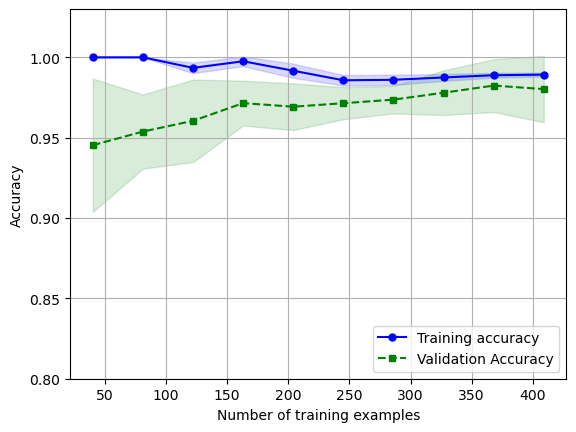

In [ ]:
# Model eval via learning curve
# Comparing training and testing accuracy for different training data set sizes
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_log_reg = make_pipeline(StandardScaler(),
                             LogisticRegression(penalty='l2',
                                                max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_log_reg,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy',)

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean,
         color = 'green', linestyle = '--',
         marker='s', markersize=5,
         label = 'Validation Accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])

plt.show()

In [ ]:
# Creating a validation curve
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator=pipe_log_reg,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training Accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', marketsize=5,
         label='Validation accuracy')

plt.fill_between(param_range, )